In [305]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


In [306]:
data = loadmat('example1kinect.mat')
amplitude_image = data['amplitudes1']
distance_image = data['distances1']
point_cloud = data['cloud1']

In [307]:
amplitude_image.shape

(424, 512)

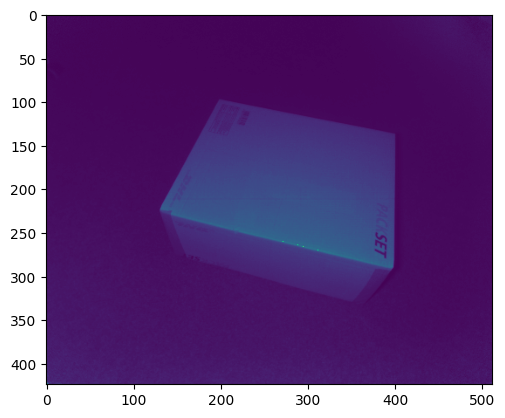

In [308]:
plt.imshow(amplitude_image)
plt.show()

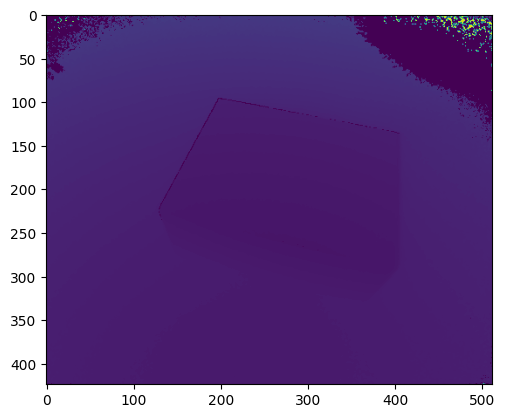

In [309]:
plt.imshow(distance_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


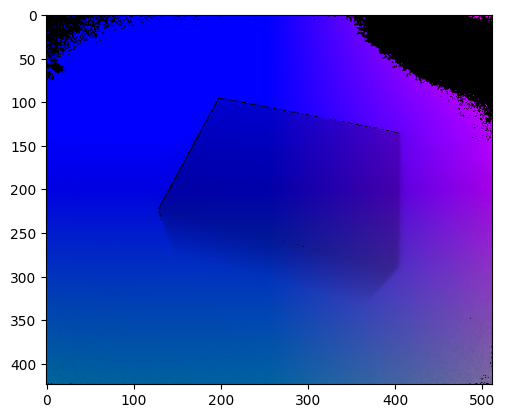

In [310]:
plt.imshow(point_cloud)
plt.show()

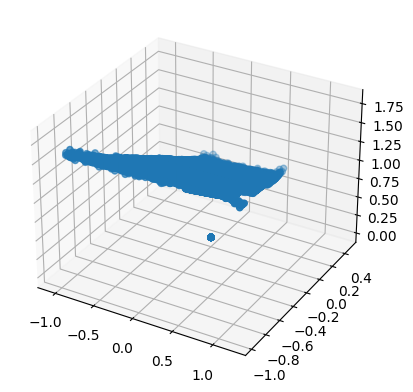

In [311]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:,:,0], point_cloud[:,:,1], point_cloud[:,:,2])
plt.show()

In [476]:
import numpy as np
import random

def compute_plane(points):
    # Calculate plane defined by three points using cross product
    vector1 = points[1] - points[0]
    vector2 = points[2] - points[0]
    normal_vector = np.cross(vector1, vector2)
    d = -points[0].dot(normal_vector)
    return normal_vector, d

def distances_to_plane(plane, points):
    normal_vector, d = plane
    numerators = abs(np.dot(points, normal_vector) + d)
    denominator = np.linalg.norm(normal_vector)
    distances = numerators / denominator
    return distances

def ransac_plane_fitting(points, max_iterations, threshold):
    best_inliers_count = 0
    best_plane = None
    best_inliers_indices = []

    for _ in range(max_iterations):
        # Randomly select three points
        indices = random.sample(range(points.shape[0]), 3)
        sample_points = points[indices]
        plane = compute_plane(sample_points)

        # Calculate distances of all points to the plane
        distances = distances_to_plane(plane, points)

        # Find inliers
        inliers_indices = np.where(distances < threshold)[0]    

        if len(inliers_indices) > best_inliers_count:
            best_inliers_count = len(inliers_indices)
            best_plane = plane
            best_inliers_indices = inliers_indices

        best_inliers_points = points[best_inliers_indices]

    return best_plane, best_inliers_indices,best_inliers_points

# Example
points = np.array([[0,0,1], [1,0,1], [0,1,1], [1,1,1], [0.5,0.5,2]]) # Add your 3D point cloud data here
max_iterations = 100
threshold = 0.1

best_plane, best_inliers_indices, best_inliers_points = ransac_plane_fitting(points, max_iterations, threshold)
print("Best plane:", best_plane)

def generate_mask_from_inliers(inliers, image_shape):
    """Generate a binary mask from inliers."""
    mask = np.zeros(image_shape)
    for inlier in inliers:
        y, x = np.divmod(inlier, image_shape[1])  # Convert linear index to 2D coordinates
        mask[int(y), int(x)] = 1  # Mark as inlier
    return mask



Best plane: (array([ 0.,  0., -1.]), 1.0)


In [477]:
max_iterations = 1000
threshold = 0.1
points = point_cloud.reshape(-1, 3)
best_plane, best_inliers_indices, best_inliers_points= ransac_plane_fitting(points, max_iterations, threshold)
print("Best plane:", best_plane)
print("Number of inliers:", len(best_inliers))

/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_95949/3350747337.py:16: RuntimeWarning: invalid value encountered in divide
  distances = numerators / denominator


Best plane: (array([-0.00054381, -0.06403201, -0.0775866 ]), 0.06573257419790862)
Number of inliers: 163038


In [478]:
def generate_mask_from_inliers(inliers, image_shape):
    """Generate a binary mask from inliers."""
    mask = np.zeros(image_shape)
    for inlier in inliers:
        y, x = np.divmod(inlier, image_shape[1])  # Convert linear index to 2D coordinates
        mask[int(y), int(x)] = 1  # Mark as inlier
    return mask


/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_95949/3350747337.py:16: RuntimeWarning: invalid value encountered in divide
  distances = numerators / denominator


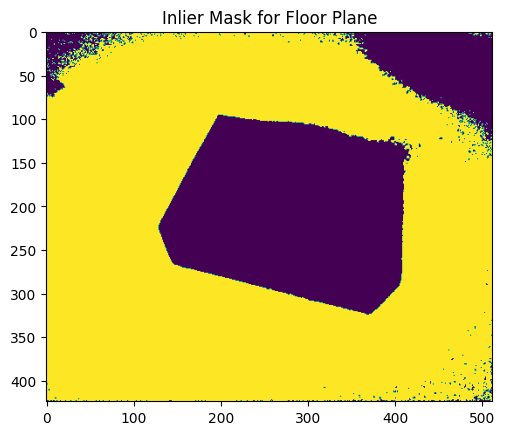

In [479]:
points = point_cloud.reshape(-1, 3)
valid_indices = np.where(points[:, 2] != 0)
valid_point_cloud = points[valid_indices]
max_iterations = 3000
threshold = 0.035
best_plane, best_inliers_indices, best_inliers_points = ransac_plane_fitting(points, max_iterations, threshold)

# Generate mask
mask = generate_mask_from_inliers(best_inliers_indices, (424, 512))  # Adjust shape accordingly

# Visualize
plt.imshow(mask)
plt.title('Inlier Mask for Floor Plane')
plt.show()

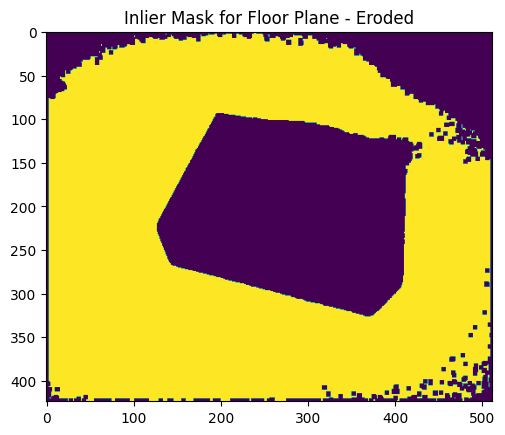

In [339]:
import cv2
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        
# Erosion
eroded = cv2.erode(mask, kernel, iterations=1)

# Dilation
dilated = cv2.dilate(mask, kernel, iterations=5)

# Opening
opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Closing
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Visualize
plt.imshow(eroded)
plt.title('Inlier Mask for Floor Plane - Eroded')
plt.show()

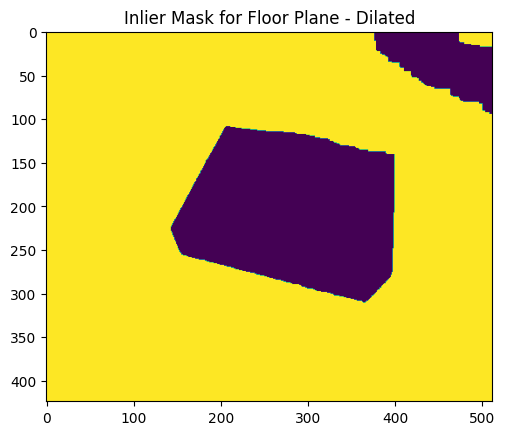

In [340]:
# Visualize
plt.imshow(dilated)
plt.title('Inlier Mask for Floor Plane - Dilated')
plt.show()

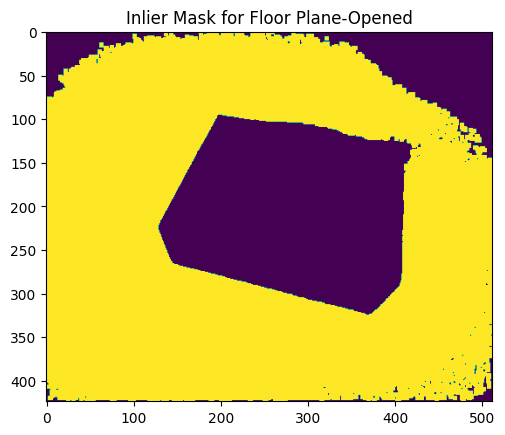

In [341]:
# Visualize
plt.imshow(opened)
plt.title('Inlier Mask for Floor Plane-Opened')
plt.show()

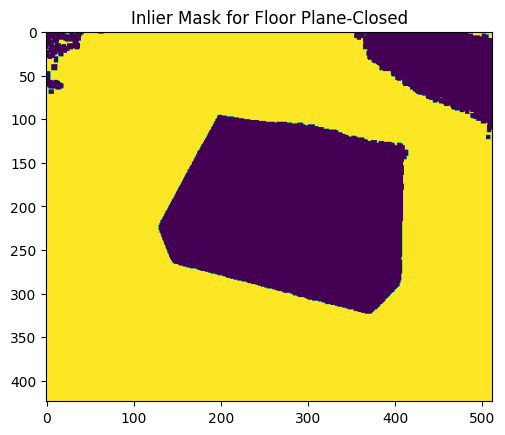

In [342]:
# Visualize
plt.imshow(closed)
plt.title('Inlier Mask for Floor Plane-Closed')
plt.show()

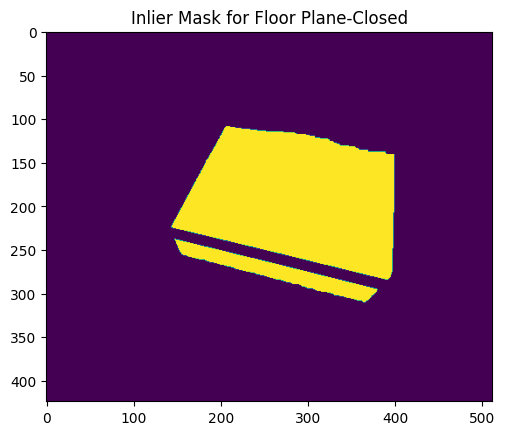

In [448]:
inverse_mask = 1 - mask  # This will give you the regions that are not part of the floor
# Visualize
plt.imshow(inverse_mask)
plt.title('Inlier Mask for Floor Plane-Closed')
plt.show()

In [328]:
import numpy as np
from scipy import ndimage

# Assuming point_cloud is given and the above RANSAC functions are already defined

# 1. Use RANSAC to find the dominant plane (most likely the floor)
points = point_cloud.reshape(-1, 3)
max_iterations = 1000
threshold = 0.1
floor_plane, floor_inliers = ransac_plane_fitting(points, max_iterations, threshold)

# 2. Remove the floor points to get the remaining points
non_floor_points = np.delete(points, floor_inliers, axis=0)

# 3. Run RANSAC again to find the top of the box
top_plane, top_inliers = ransac_plane_fitting(filtered_points, max_iterations, threshold)

# 4. Generate a mask for the inliers of the top of the box
image_shape = point_cloud.shape[:2]  # Assuming point_cloud has shape (Height, Width, 3)
mask = generate_mask_from_inliers(top_inliers, image_shape)

# 5. Use SciPy's morphological operations to identify the largest connected component

# First, you might want to close small holes in the mask
mask_closed = ndimage.morphology.binary_closing(mask)

# Label connected components
labeled, num_features = ndimage.label(mask_closed)

# Find the largest connected component
sizes = ndimage.sum(mask_closed, labeled, range(num_features + 1))
mask_clean = sizes == sizes.max()

# Convert back to binary mask format
final_mask = (labeled == mask_clean.argmax())

# At this point, `final_mask` is a binary mask representing the top of the box


/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_95949/3292937617.py:16: RuntimeWarning: invalid value encountered in divide
  distances = numerators / denominator
/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_95949/1562452863.py:25: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask_closed = ndimage.morphology.binary_closing(mask)


In [374]:
dilated*amplitude_image

array([[    0.,  1711.,  2618., ..., 11774., 17148.,     0.],
       [    0.,  3487.,  3862., ...,  6204.,  6588.,     0.],
       [    0.,  2883.,  1739., ...,  6702.,  7729.,     0.],
       ...,
       [    0.,  9210.,  7708., ...,  4909.,  4566.,     0.],
       [    0., 17712., 13374., ...,  9831.,  7632.,     0.],
       [    0., 33642., 16712., ...,  6590.,  7424.,     0.]])

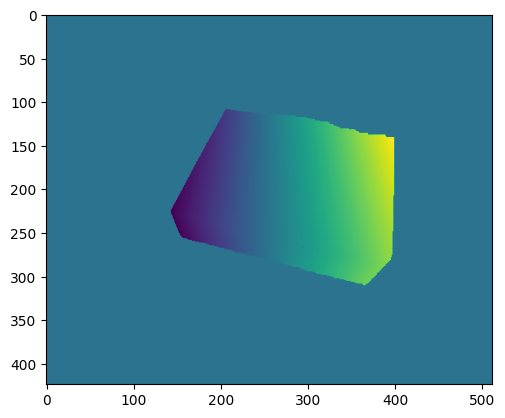

In [383]:
plt.imshow((1-dilated)*point_cloud[:,:,0])

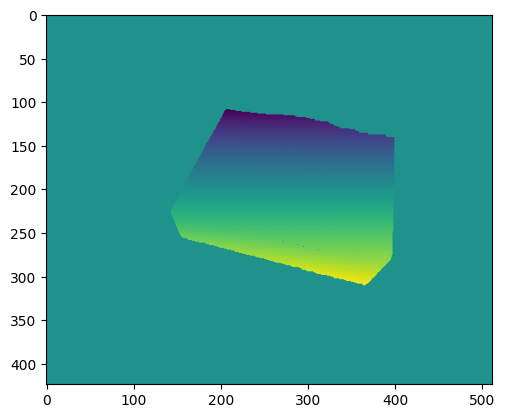

In [384]:
plt.imshow((1-dilated)*point_cloud[:,:,1])

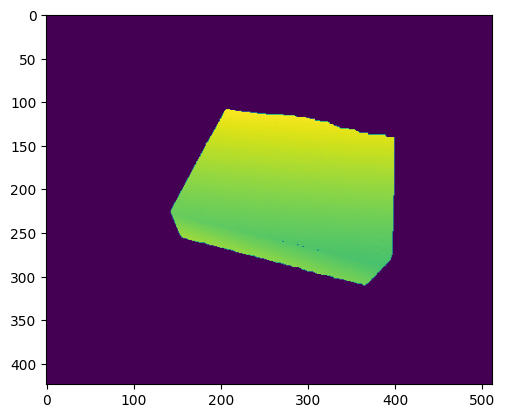

In [381]:
plt.imshow((1-dilated)*point_cloud[:,:,2])

In [ ]:
points = point_cloud.reshape(-1, 3)
points[]

In [ ]:
import numpy as np

nonfloor_cloud = np.stack(((1-mask)*point_cloud[:,:,0], (1-mask)*point_cloud[:,:,1], (1-mask)*point_cloud[:,:,2]), axis=-1)

In [451]:
nonfloor_cloud.shape

(424, 512, 3)

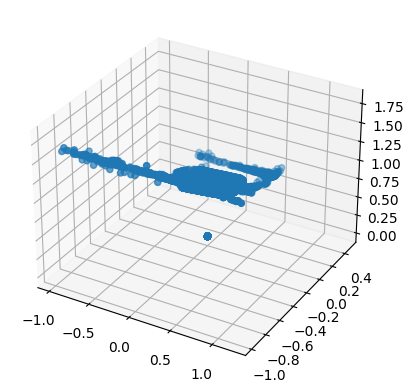

In [452]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(nonfloor_cloud[:,:,0], nonfloor_cloud[:,:,1], nonfloor_cloud[:,:,2])
plt.show()

/var/folders/fx/tg4mrb6x7s737ny3gw20xr4w0000gn/T/ipykernel_95949/3609060742.py:16: RuntimeWarning: invalid value encountered in divide
  distances = numerators / denominator


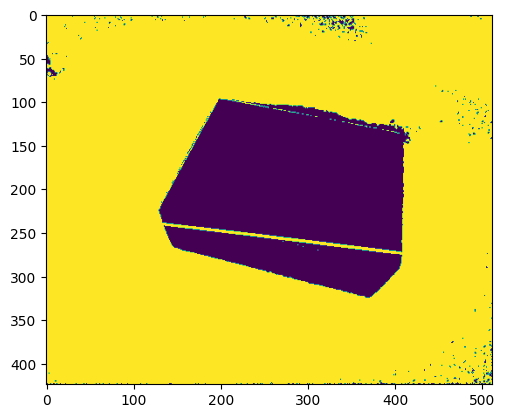

In [471]:
points = nonfloor_cloud.reshape(-1, 3)
valid_indices = np.where(points[:, 2] != 0)
valid_point_cloud = points[valid_indices]

max_iterations = 3000
threshold = 0.003
best_plane, best_inliers_indices, best_inliers_points = ransac_plane_fitting(points, max_iterations, threshold)

# Generate mask
top_layer_mask = generate_mask_from_inliers(best_inliers_indices, (424, 512))  # Adjust shape accordingly

# Visualize
plt.imshow(top_layer_mask)
plt.show()

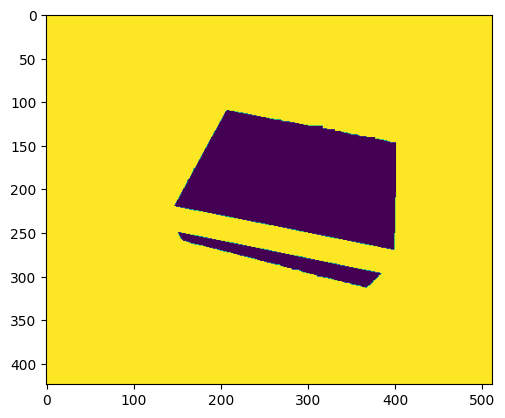

In [454]:
import cv2
kernel_size = 10
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        
# Erosion
eroded = cv2.erode(top_layer_mask, kernel, iterations=1)

# Dilation
dilated = cv2.dilate(top_layer_mask, kernel, iterations=2)

# Opening
opened = cv2.morphologyEx(top_layer_mask, cv2.MORPH_OPEN, kernel)

# Closing
closed = cv2.morphologyEx(top_layer_mask, cv2.MORPH_CLOSE, kernel)

# Visualize
plt.imshow(dilated)
plt.show()

In [467]:
from scipy.ndimage import label

labeled_mask, num_features = label(top_layer_mask)
largest_component = np.argmax(np.bincount(labeled_mask.flat)[1:]) + 1
refined_mask = (labeled_mask == largest_component)

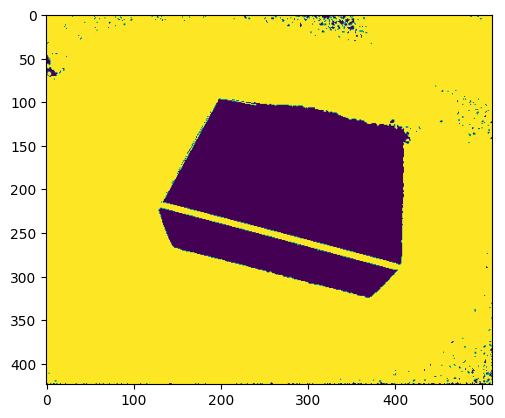

In [466]:

# Visualize
plt.imshow(refined_mask)
plt.show()

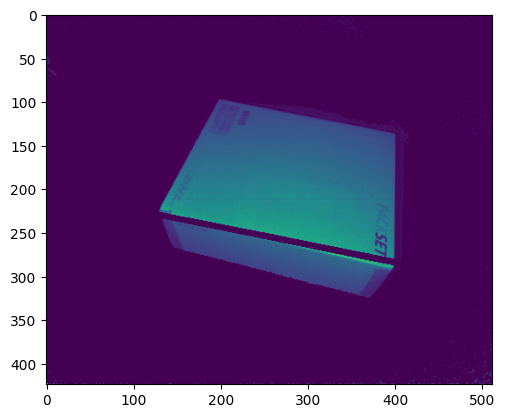

In [457]:


# Visualize
plt.imshow((1-top_layer_mask)*point_cloud)
plt.show()

In [482]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
from scipy.ndimage import label

# Sample data (replace with your actual cloud data)
# cloud_data = np.random.rand(424, 512, 3)

# 1. Prepare the data
X = point_cloud.reshape(-1, 3)
y = np.ones(X.shape[0])

# 2. Fit RANSAC to determine the planes
ransac = RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_

# We now have the largest plane. For the second largest plane,
# we will mask out the largest and rerun RANSAC
X_second = X[~inlier_mask]
y_second = np.ones(X_second.shape[0])
ransac.fit(X_second, y_second)
inlier_mask_second = ransac.inlier_mask_

# Convert the inlier mask of second plane to the shape of cloud_data
complete_mask = np.zeros_like(y, dtype=bool)
complete_mask[~inlier_mask] = inlier_mask_second

mask_3d = complete_mask.reshape(424, 512)

# 3. Extract points for the second largest plane
points_second_plane = X[complete_mask].reshape(-1, 3)

# Optional: Extract the largest connected component, if required
labeled_mask, _ = label(mask_3d)
counts = np.bincount(labeled_mask.flat)
largest_label = counts[1:].argmax() + 1
refined_mask = labeled_mask == largest_label


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by RANSACRegressor.

In [487]:
inlier_mask.reshape(424,512)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [485]:
mask1 = generate_mask_from_inliers(inlier_mask, (424, 512))  # Adjust shape accordingly


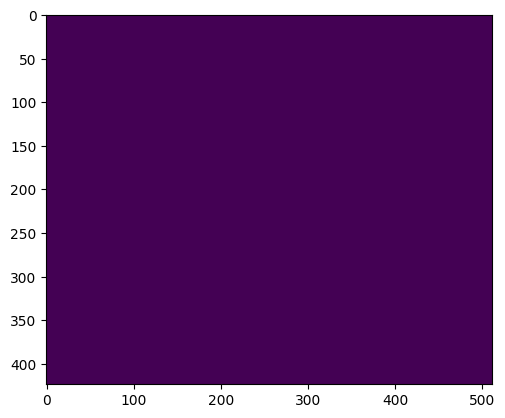

In [488]:


# Visualize
plt.imshow(inlier_mask.reshape(424,512))
plt.show()

In [490]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from scipy.ndimage import label

# Assuming cloud_data has shape (424, 512, 3)
# cloud_data = ...

X = point_cloud[:, :, :2].reshape(-1, 2)  # X and Y coordinates
Z = point_cloud[:, :, 2].flatten()        # Z coordinates

# Using RANSAC to robustly fit a plane
ransac = RANSACRegressor()
ransac.fit(X, Z)
inlier_mask = ransac.inlier_mask_

# Removing the inliers of the largest plane to detect the second largest plane
X_second = X[~inlier_mask]
Z_second = Z[~inlier_mask]
ransac.fit(X_second, Z_second)
inlier_mask_second = ransac.inlier_mask_

# Convert the inlier mask of second plane to the shape of cloud_data
complete_mask = np.zeros_like(Z, dtype=bool)
complete_mask[~inlier_mask] = inlier_mask_second
mask_3d = complete_mask.reshape(424, 512)

# Extract the largest connected component
labeled_mask, _ = label(mask_3d)
counts = np.bincount(labeled_mask.flat)
largest_label = counts[1:].argmax() + 1
refined_mask = labeled_mask == largest_label


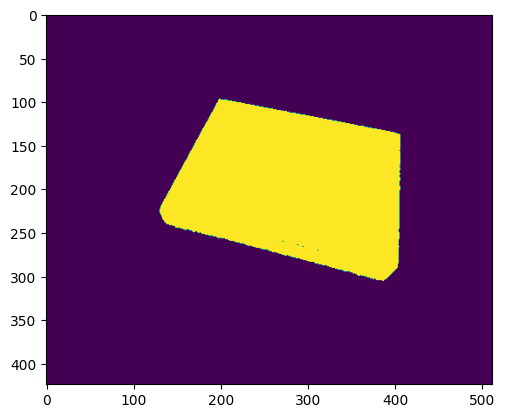

In [492]:


# Visualize
plt.imshow(mask_3d)
plt.show()

In [503]:
# Assuming cloud_data has shape (424, 512, 3)
# cloud_data = ...

X = nonfloor_cloud[:, :, :2].reshape(-1, 2)  # X and Y coordinates
Z = nonfloor_cloud[:, :, 2].flatten()        # Z coordinates

# Using RANSAC to robustly fit a plane
ransac = RANSACRegressor()
ransac.fit(X, Z)
inlier_mask = ransac.inlier_mask_



# Convert the inlier mask of second plane to the shape of cloud_data
mask_3d = inlier_mask.reshape(424, 512)

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


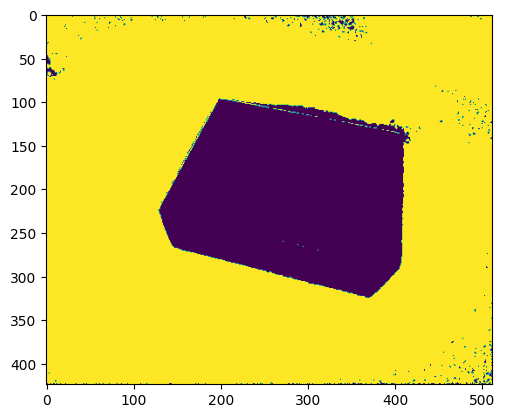

In [504]:


# Visualize
plt.imshow(mask_3d)
plt.show()